In [77]:
import os
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

In [78]:
df = pd.read_csv("US_youtube_trending_data.csv")

In [79]:
category_ids = dict()
with open('US_category_id.json', 'r') as f:
    category_data = json.load(f)

for category in category_data['items']:
    category_ids[category['id']] = category['snippet']['title']


In [80]:
df['category_id_str'] = df['categoryId'].astype('string')
df['category_name'] = df['category_id_str'].map(category_ids)
df.drop('category_id_str', axis=1, inplace=True)

In [81]:
df[['publishedAt', 'trending_date']] = df[['publishedAt', 'trending_date']].apply(pd.to_datetime)
df['days_to_trend'] = (df['trending_date'] - df['publishedAt']).dt.days

df['published_dow'] = df['publishedAt'].dt.day_name()

In [82]:
df = df.reindex(columns=['video_id', 'title', 'channelId', 'channelTitle', 'categoryId', 'category_name',
        'publishedAt', 'published_dow', 'trending_date', 'days_to_trend','comment_count', 'view_count',
        'likes', 'dislikes', 'comments_disabled', 'thumbnail_link', 'ratings_disabled', 'description', 'tags'])
df.drop('thumbnail_link', axis=1, inplace=True)
df.rename(columns = {'channelId':'channel_id', 'channelTitle':'channel_title', 'publishedAt': 'published_at',
                     'categoryId': 'category_id'}, inplace = True)
df.head()

,video_id,title,channel_id,channel_title,category_id,category_name,published_at,published_dow,trending_date,days_to_trend,comment_count,view_count,likes,dislikes,comments_disabled,ratings_disabled,description,tags
0,3C66w5Z0ixs,I ASKED HER TO BE MY GIRLFRIEND...,UCvtRTOMP2TqYqu51xNrqAzg,Brawadis,22,People & Blogs,2020-08-11 19:20:14+00:00,Tuesday,2020-08-12 00:00:00+00:00,0,35313,1514614,156908,5855,False,False,SUBSCRIBE to BRAWADIS ▶ http://bit.ly/Subscrib...,brawadis|prank|basketball|skits|ghost|funny vi...
1,M9Pmf9AB4Mo,Apex Legends | Stories from the Outlands – “Th...,UC0ZV6M2THA81QT9hrVWJG3A,Apex Legends,20,Gaming,2020-08-11 17:00:10+00:00,Tuesday,2020-08-12 00:00:00+00:00,0,16549,2381688,146739,2794,False,False,"While running her own modding shop, Ramya Pare...",Apex Legends|Apex Legends characters|new Apex ...
2,J78aPJ3VyNs,I left youtube for a month and THIS is what ha...,UCYzPXprvl5Y-Sf0g4vX-m6g,jacksepticeye,24,Entertainment,2020-08-11 16:34:06+00:00,Tuesday,2020-08-12 00:00:00+00:00,0,40221,2038853,353787,2628,False,False,I left youtube for a month and this is what ha...,jacksepticeye|funny|funny meme|memes|jacksepti...
3,kXLn3HkpjaA,XXL 2020 Freshman Class Revealed - Official An...,UCbg_UMjlHJg_19SZckaKajg,XXL,10,Music,2020-08-11 16:38:55+00:00,Tuesday,2020-08-12 00:00:00+00:00,0,7647,496771,23251,1856,False,False,Subscribe to XXL → http://bit.ly/subscribe-xxl...,xxl freshman|xxl freshmen|2020 xxl freshman|20...
4,VIUo6yapDbc,Ultimate DIY Home Movie Theater for The LaBran...,UCDVPcEbVLQgLZX0Rt6jo34A,Mr. Kate,26,Howto & Style,2020-08-11 15:10:05+00:00,Tuesday,2020-08-12 00:00:00+00:00,0,2196,1123889,45802,964,False,False,Transforming The LaBrant Family's empty white ...,The LaBrant Family|DIY|Interior Design|Makeove...


In [40]:
print('Number of entries:\t{rows}'.format(rows=df.shape[0]))

Number of entries:	166590


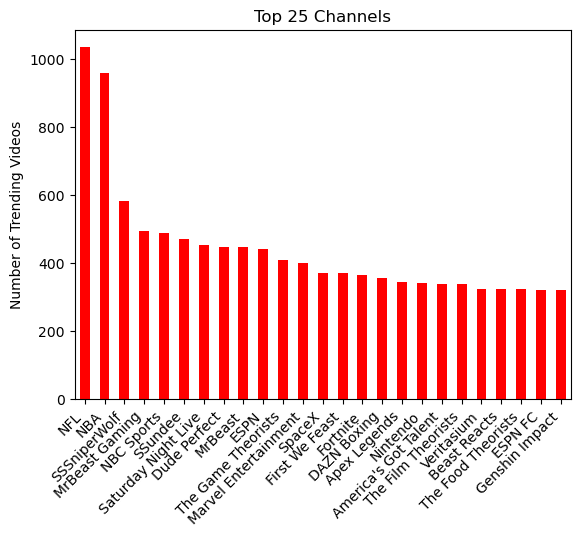

In [73]:
top_25_channels = df.groupby(['channel_title']).size().sort_values(ascending=False).head(25)

chart = top_25_channels.plot(kind='bar', color='red')
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
chart.set(
    title='Top 25 Channels',
    xlabel='',
    ylabel='Number of Trending Videos'
)

plt.savefig('images/top_25.png', bbox_inches = "tight", dpi=300)
plt.show()


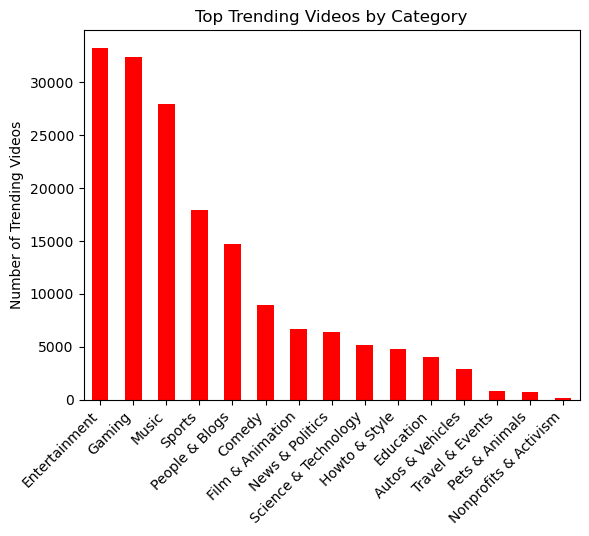

In [75]:
category_counts = df.groupby(['category_name']).size().sort_values(ascending=False)

chart = category_counts.plot(kind='bar', color='red')
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
chart.set(
    title='Top Trending Videos by Category',
    xlabel='',
    ylabel='Number of Trending Videos'
)

plt.savefig('images/top_categories.png', bbox_inches = "tight", dpi=300)
plt.show()

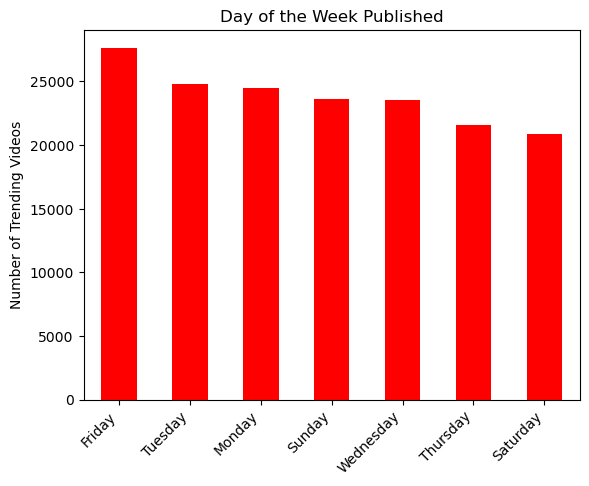

In [92]:
day_published = df.groupby(['published_dow']).size().sort_values(ascending=False)

chart = day_published.plot(kind='bar', color='red')
chart.set_xticklabels(chart.get_xticklabels(), rotation=45, horizontalalignment='right')
chart.set(
    title='Day of the Week Published',
    xlabel='',
    ylabel='Number of Trending Videos'
)

plt.savefig('images/day_published.png', bbox_inches = "tight", dpi=300)
plt.show()

In [90]:
def get_sentiment(text):
    analyzer = SentimentIntensityAnalyzer()
    sentiment_dict = analyzer.polarity_scores(text)
    if sentiment_dict['compound'] >= 0.05:
        return 'positive'
    elif sentiment_dict['compound'] <= -0.05:
        return 'negative'
    else:
        return 'neutral'
    
df = df.assign(desc_sentiment = lambda x: get_sentiment(x))

print('Count - unique description sentiments:\t{count}'.format(count=len(pd.unique(df['desc_sentiment']))))

df.drop('desc_sentiment', axis=1, inplace=True)

Count - unique description sentiments:	1


In [83]:
df2 = df.copy()
df2.sort_values(by = 'trending_date', ascending=False, inplace=True)
df2.reset_index(inplace=True)
df2.drop(df2[df2['comments_disabled'] == True].index, inplace = True)
n = len(df2.axes[0]) - 120
df2.drop(df2.tail(n).index, inplace=True)

In [10]:
def write_comments_to_json(video_id):
    result = {'video_id': video_id}
    
    driver = webdriver.Chrome()
    driver.get('https://www.youtube.com/watch?v={id}'.format(id=video_id))
    
    WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.ID, 'description')))

    html = WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.TAG_NAME, 'html')))
    html.send_keys(Keys.PAGE_DOWN)
    html.send_keys(Keys.PAGE_DOWN)
    WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.ID, 'contents')))
    for i in range(10):
        html.send_keys(Keys.END)
        time.sleep(2)
    
    comment_elems = driver.find_elements(By.XPATH, '//*[@id="content-text"]')
    
    comments = [elem.text for elem in comment_elems][0:100]
    if len(comments) < 100:
        pass
    else:
        result['comments'] = comments
        with open("comments/{filename}.json".format(filename=video_id), 'w') as f:
            json.dump(result, f)
        
    driver.close()

video_ids = df2["video_id"].to_list()

for video_id in video_ids:
    write_comments_to_json(video_id)


In [11]:
results = list()
analyzer = SentimentIntensityAnalyzer()
directory = 'comments'
 
for filename in os.listdir(directory):
    fp = os.path.join(directory, filename)
    if os.path.isfile(fp) and fp.endswith('.json'):
        with open(fp, 'r') as f:
            data = json.load(f)
            result = {'video_id': data['video_id'], 'positive': 0, 'negative': 0, 'neutral': 0}
            for comment in data["comments"]:
                sentiment_dict = analyzer.polarity_scores(comment)
                if sentiment_dict['compound'] >= 0.05:
                    result['positive'] += 1
                elif sentiment_dict['compound'] <= -0.05:
                    result['negative'] += 1
                else:
                    result['neutral'] += 1
            results.append(result)

df3 = pd.DataFrame.from_dict(results)


In [84]:
df4 = pd.merge(df3, df2,  on='video_id', how='left')
df4 = df4.drop(columns=['index'])
df4.to_csv('output/ytsentiment.csv', index=False)